<a href="https://colab.research.google.com/github/carlotta-marchis/breast-cancer-detection/blob/master/breast_cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Invasive Ductal Carcinoma (IDC) Detection

Invasive ductal carcinoma (IDC) is the most common type of breast cancer, accounting for about 80% of all of it. Moreover, breast cancer is the most common type of cancer in women worldwide. Therefore, the development of automated diagnosis support systems for breast cancer detection is an active field of research.

## Motivation 
	
Breast cancer diagnosis usually consists of several steps, including palpation, mammography or ultrasound imaging and breast tissue biopsy. In the particular case of IDC, which is the most common type of breast cancer, a very important step in the diagnosis process is to grade its aggressiveness. To do so, pathologists usually focus on the regions of the mount sample where IDC is present. The automation of the detection of the exact regions of IDC inside of a whole mount slide could help reduce costs and time of the test. 

As first step in the development of this project we will train a simple CNN model to classify breast histopathology images.


## The Data

The **breast histopathology images** used for this project are publicly available on [Kaggle](https://www.kaggle.com/paultimothymooney/breast-histopathology-images). The dataset consists of 277,524 patches of size 50 x 50 that were extracted from 162 whole mount slide images of breast cancer specimens scanned at 40x. 198,738 of the patches are negative to IDC (**IDC(-)**), while 78,786 patches contain IDC (**IDC(+)**).

The patch file name have the format: *u_xX_yY_classC.png*, e.g. 14157_idx5_x1401_y301_class0.png, where:
- *u* is the patient ID;
-  *X* and *Y* are the x- and y-coordinates from which the patch was cropped from respectively;
- *C* is the class, with 0 representing IDC(-) and 1 IDC(+).



### Importing the Data

In [0]:
import numpy as np 
import pandas as pd 
import os

np.random.seed(123)

In [52]:
# Downloading the dataset from Kaggle
os.environ['KAGGLE_USERNAME'] = "username" 
os.environ['KAGGLE_KEY'] = "key" 
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

breast-histopathology-images.zip: Skipping, found more recently modified local copy (use --force to force download)


### Data Exploration

Firstly we extract the files and check that we have the complete dataset, consisting of 277,524 images.

In [54]:
from glob import glob # Glob is used to extract files from a folder 
Data = glob('IDC_regular_ps50_idx5/**/*.png', recursive=True) 
print(len(Data))

277524


> We have a total of 277,524 image files.

Then we check the dimensions of the images:

In [55]:
from PIL import Image 

dim=list()
x=1
for images in (Data):
    img = Image.open(images)
    size = img.size
    if size not in dim:
        dim.append(size)
        x+=1
    if(x>3): # Break the loop after 3 different dimensions are recorded
        break
print(dim)


[(50, 50), (50, 14), (42, 50)]


> Not all images have the same dimensions, therefore we will need to make the dimensions all equal for our network to work at its best.

### Data Extraction and Visualization

Here we define a function to show the images, and we plot the first N.

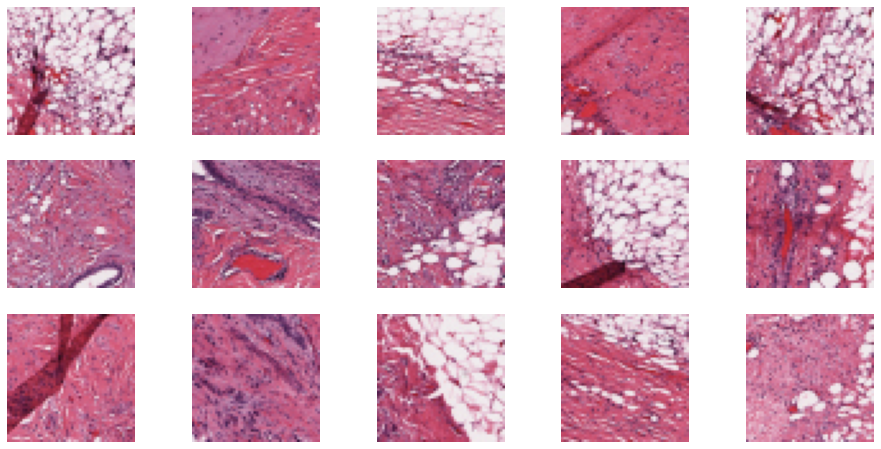

In [56]:
import cv2 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

# Function to view an image
def view_image(image): 
    image_cv = cv2.imread(image) 
    plt.imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)); 
    plt.axis('off');

# Plot the first N images
n_rows = 3
n_cols = 5
N = n_rows*n_cols
plt.figure(figsize=(16,8))
for i, image in enumerate(Data[:N]):
  plt.subplot(n_rows, n_cols, i+1)
  view_image(image)

Now lets look at the pixel value ranges that our images have:

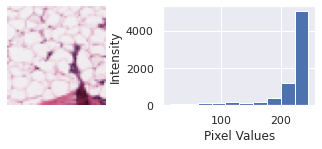

In [57]:
# Plot histogram of pixel values VS intensities
def hist_plot(image): 
    img = cv2.imread(image)
    plt.subplot(2, 2, 1)
    view_image(image)
    plt.subplot(2, 2, 2)
    plt.hist(img.ravel()) 
    plt.xlabel('Pixel Values')
    plt.ylabel('Intensity')
hist_plot(Data[29])
    

> The pixel values range from 0 to 255. We will rescale them to 1.

Now we are going to extract the class of each image from the corresponding file name.

In [58]:
labels = []
for file_name in Data:
  labels.append([int(file_name[-5])])

labels = pd.DataFrame(labels, columns = ['Classes'])
labels.head()

,Classes
0,1
1,1
2,1
3,1
4,1


> 0 represents **IDC(-)** and 1 represents **IDC(+)**

In [59]:
labels.shape

(277524, 1)

Here we plot the class distribution of our dataset.

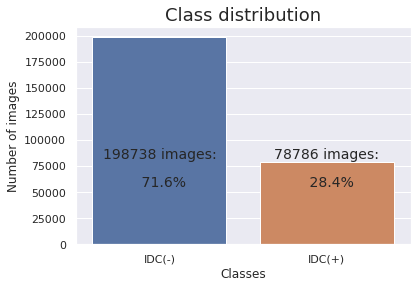

In [60]:
sns.countplot(x='Classes', data=labels)
plt.ylabel('Number of images');
plt.title('Class distribution', fontsize=18)
plt.xticks(ticks=[0,1], labels=['IDC(-)', 'IDC(+)'])

plt.text(0, 55000, str(format(labels['Classes'].value_counts(normalize=True)[0]*100,'7.1f')) + '% ', size=14, horizontalalignment='center')
plt.text(0, 82000, str((labels['Classes']==0).sum()) + ' images:', size=14, horizontalalignment='center')
plt.text(1, 55000, str(format(labels['Classes'].value_counts(normalize=True)[1]*100,'7.1f')) + '% ', size=14, horizontalalignment='center');
plt.text(1, 82000, str((labels['Classes']==1).sum()) + ' images:', size=14, horizontalalignment='center');

> The dataset has **imbalanced classes**. This is a common problem with medical data, with which we will have to deal.

Now we define a function that plots the image together with its class. As a check, the class is printed in green if the corresponding label in the `labels` DataFrame matches, otherwise in red.

In [0]:
def check_class(images, labels, i):
  image, label = images[i], labels[i]
  view_image(image)
  plt.title('Class' + str(label), color = 'g' if image[-5]==str(label) else 'r')

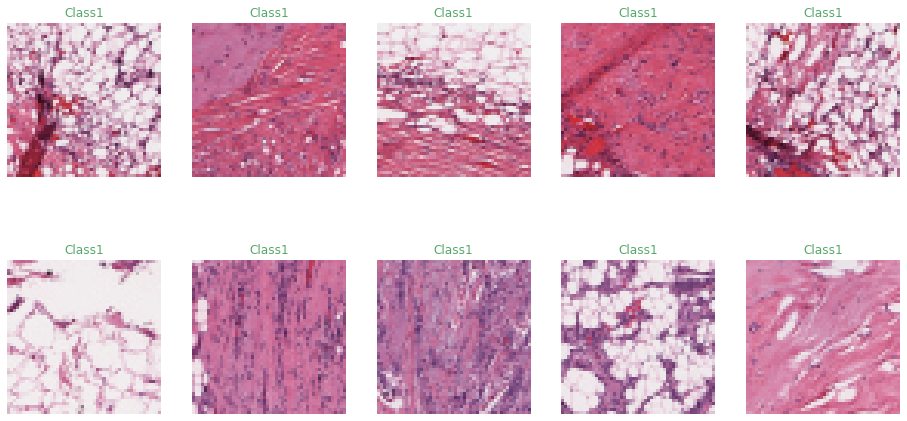

In [62]:
# Plot the first n IDC(+) images and n IDC(-) images
n = 5
plt.figure(figsize=(16,8))

for i in range(n):
  plt.subplot(2, n, i+1)
  check_class(Data, labels.Classes, i)
  plt.subplot(2,n,2*n-i)
  check_class(Data, labels.Classes, 198738+i)

### Summary

The main things we will have to keep in mind along the project are:
- The image sizes are not consistent throughout the dataset, therefore we will have to resize them.
- The classes are imbalanced, hence we might need to use some techniques for dealing with imbalanced data.

## Data Preprocessing

In order to remove any pattern, we shuffle the images.

In [0]:
from sklearn.utils import shuffle
Data, labels= shuffle(Data, labels)

We now resize the images and then load them into `data`, which will then contain the 50 x 50 RGB pixel values for each image.

In [64]:
from tqdm import tqdm
data=list()
for img in tqdm(Data):
    image = cv2.imread(img)
    data.append(cv2.resize(image,(50,50)))

100%|██████████| 277524/277524 [02:54<00:00, 1589.09it/s]


In [65]:
data = np.array(data)
data.shape

(277524, 50, 50, 3)

The dataset is very large. Considering the limited RAM resources we will use only part of it to debug the code and tune the hyperparameters of our neural network model.

Here we also rescale the pixel values to 1.

In [0]:
X = data[:100000]/255.
y = labels.Classes[:100000].to_numpy()

Now we will split our data into training and test set.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

We also need a validation set in order to check overfitting. We will split the test set further:

In [0]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2)

## A Simple CNN Model

Now that the data is ready to be fed into the neural network we can build our model.

In [0]:
# Configuring the neural network architecture
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
        keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(50,50,3)),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
                          ])

Here is the complete model architecture:

In [70]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 48, 48, 64)        1792      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               9437440   
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 9,439,746
Trainable params: 9,439,746
Non-trainable params: 0
_________________________________________________________________


Now we will compile and train the model.

In [71]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
2188/2188 [==============================] - 10s 5ms/step - loss: 0.4271 - accuracy: 0.8102 - val_loss: 0.3647 - val_accuracy: 0.8388
Epoch 2/5
2188/2188 [==============================] - 10s 5ms/step - loss: 0.3845 - accuracy: 0.8312 - val_loss: 0.3634 - val_accuracy: 0.8427
Epoch 3/5
2188/2188 [==============================] - 10s 5ms/step - loss: 0.3694 - accuracy: 0.8388 - val_loss: 0.3474 - val_accuracy: 0.8517
Epoch 4/5
2188/2188 [==============================] - 10s 5ms/step - loss: 0.3574 - accuracy: 0.8456 - val_loss: 0.3528 - val_accuracy: 0.8588
Epoch 5/5
2188/2188 [==============================] - 10s 5ms/step - loss: 0.3434 - accuracy: 0.8532 - val_loss: 0.3436 - val_accuracy: 0.8565


This model reaches an accuracy of about 0.85 (or 85%) on the training data.

### Evaluating the model

188/188 - 1s - loss: 0.3436 - accuracy: 0.8565
The accuracy reached by the model is: 0.8565000295639038


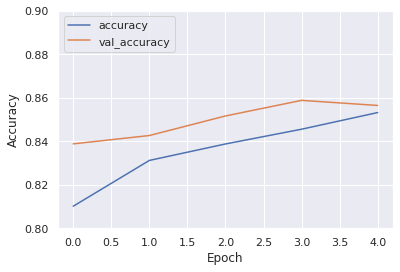

In [72]:
plt.plot(history.epoch, history.history['accuracy'], label='accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 0.9])
plt.legend(loc='upper left');


test_loss, test_acc = model.evaluate(X_val,  y_val, verbose=2);
print('The accuracy reached by the model is: ' + str(test_acc))

This CNN has achieved a test accuracy of about 85%.

### Making predictions

Here we use the trained model to predict the labels of the images in `X_test`.

In [0]:
predictions_prob = model.predict(X_test)

In [0]:
predictions = np.array([np.argmax(predictions_prob[i]) for i in range(len(predictions_prob))])

In [75]:
accuracy = (predictions == y_test).sum()/len(y_test)
accuracy

0.8480416666666667

### Verifyig predictions

Here we define a function to verify the predictions made by our simple CNN model. The function prints the image together with its predicted label. The label is green when it corresponds to the true label, red otherwise.

In [0]:
def check_predictions(images, labels, predictions, i):
  image, label, prediction = images[i], labels[i], predictions[i]
  plt.imshow(image)
  plt.axis('off')

  plt.title('Class' + str(prediction), color = 'g' if label==prediction else 'r')

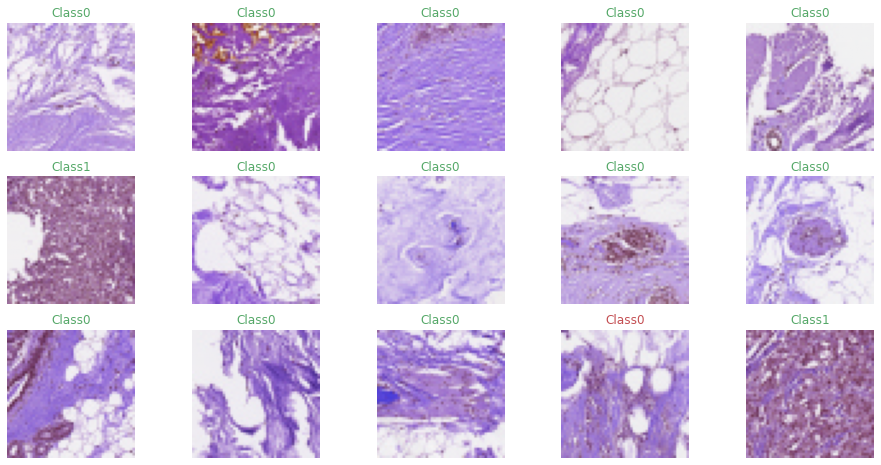

In [77]:
# Plot the first N images
n_rows = 3
n_cols = 5
N = n_rows*n_cols
plt.figure(figsize=(16,8))

for i in range(N):
  plt.subplot(n_rows, n_cols, i+1)
  check_predictions(X_test, y_test, predictions, i)

As shown by the plot above, the fourteenth image was incorrectly labelled as Class0.

To have a better understanding of the performance of our model, let's look at the confusion matrix:

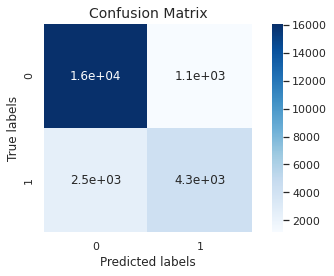

In [78]:
def plot_cm(confusion):
  sns.heatmap(confusion, annot=True, cmap='Blues', square=True)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix', size=14)
  plt.tight_layout()

from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, predictions, labels=[0,1])
plot_cm(confusion)

The confusion matrix would be diagonal if the model had predicted everything perfectly. Here we see that the matrix shows relatively few false negatives, meaning that there were relatively few IDC(-) images that were incorrectly labeled as IDC(+). However, the model over-predicts IDC(-), in fact almost half of the IDC(+) images were incorrectly classified as IDC(-). 

The big number of false negatives is probably due to the imbalanced dataset, and this issue will have to be addressed during the development of this project.

## Dealing with Class Imbalance

### Baseline model

In [0]:
# Metrics we are going to use in the models
METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

# Number of epochs and batch size
EPOCHS = 5
#BATCH_SIZE =

Here we use a more complex structure for our CNN: 2 convolutional layers in the feature extraction part and 3 fully connectedlayers in the classifier part of the model.

In [0]:
def make_model(metrics = METRICS):
  # Model architecture
  model = keras.Sequential([
        keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(50,50,3)),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Conv2D(64, (3,3), activation='relu'),
        keras.layers.MaxPooling2D((2,2)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(2, activation='softmax')
  ])
  # Compiling the model
  model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(), # Change y_train and y_val to categorical!
              metrics=metrics)

  return model

In [0]:
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_val_cat = tf.keras.utils.to_categorical(y_val)

In [82]:
# Train the model
baseline_model = make_model()
baseline_history = baseline_model.fit(X_train, y_train_cat, epochs=EPOCHS, validation_data=(X_val, y_val_cat))

Epoch 1/5
2188/2188 [==============================] - 12s 5ms/step - loss: 0.4035 - accuracy: 0.8247 - auc: 0.8983 - val_loss: 0.3637 - val_accuracy: 0.8463 - val_auc: 0.9188
Epoch 2/5
2188/2188 [==============================] - 12s 5ms/step - loss: 0.3676 - accuracy: 0.8432 - auc: 0.9165 - val_loss: 0.3351 - val_accuracy: 0.8623 - val_auc: 0.9313
Epoch 3/5
2188/2188 [==============================] - 11s 5ms/step - loss: 0.3540 - accuracy: 0.8509 - auc: 0.9227 - val_loss: 0.3492 - val_accuracy: 0.8545 - val_auc: 0.9248
Epoch 4/5
2188/2188 [==============================] - 12s 5ms/step - loss: 0.3425 - accuracy: 0.8555 - auc: 0.9278 - val_loss: 0.3385 - val_accuracy: 0.8568 - val_auc: 0.9295
Epoch 5/5
2188/2188 [==============================] - 12s 5ms/step - loss: 0.3313 - accuracy: 0.8595 - auc: 0.9326 - val_loss: 0.3355 - val_accuracy: 0.8620 - val_auc: 0.9328


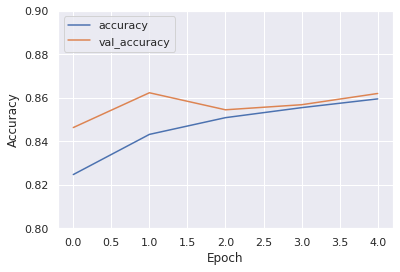

In [83]:
plt.plot(baseline_history.epoch, baseline_history.history['accuracy'], label='accuracy')
plt.plot(baseline_history.epoch, baseline_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 0.9])
plt.legend(loc='upper left');

The model reaches a val_accuracy of about 86%.

In [0]:
baseline_predictions_prob = baseline_model.predict(X_test)
baseline_predictions = np.array([np.argmax(baseline_predictions_prob[i]) for i in range(len(baseline_predictions_prob))])

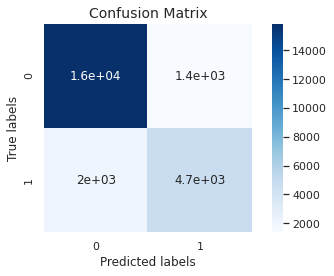

In [85]:
baseline_confusion = confusion_matrix(y_test, baseline_predictions, labels=[0,1])
plot_cm(baseline_confusion)

Here we see that 29.8% of the total positive images (IDC(+)) are incorrectly labeled as negative!
In the next section we try to address this problem by using the Keras `class_weight` paramenter.

### Weighted model

The goal is to identify images positive to IDC, but we don't have very many of those positive samples to work with. One option is to tell the classifier to heavily weight the few examples that are available. We can do this by using the Keras paramenter `class_weight`. These will cause the model to "pay more attention" to examples from an under-represented class.

In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
weights = {0:class_weights[0], 1:class_weights[1]}

In [87]:
weighted_model = make_model()

weighted_history = weighted_model.fit(
    X_train,
    y_train_cat,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_cat),
    # The class weights go here
    class_weight=weights) 

Epoch 1/5
2188/2188 [==============================] - 12s 6ms/step - loss: 0.4692 - accuracy: 0.7952 - auc: 0.8668 - val_loss: 0.4283 - val_accuracy: 0.8215 - val_auc: 0.8835
Epoch 2/5
2188/2188 [==============================] - 12s 5ms/step - loss: 0.4197 - accuracy: 0.8178 - auc: 0.8890 - val_loss: 0.3717 - val_accuracy: 0.8442 - val_auc: 0.9158
Epoch 3/5
2188/2188 [==============================] - 12s 6ms/step - loss: 0.4024 - accuracy: 0.8251 - auc: 0.8982 - val_loss: 0.3631 - val_accuracy: 0.8527 - val_auc: 0.9187
Epoch 4/5
2188/2188 [==============================] - 12s 6ms/step - loss: 0.3898 - accuracy: 0.8310 - auc: 0.9047 - val_loss: 0.3802 - val_accuracy: 0.8395 - val_auc: 0.9098
Epoch 5/5
2188/2188 [==============================] - 12s 5ms/step - loss: 0.3742 - accuracy: 0.8369 - auc: 0.9121 - val_loss: 0.4039 - val_accuracy: 0.8180 - val_auc: 0.9010


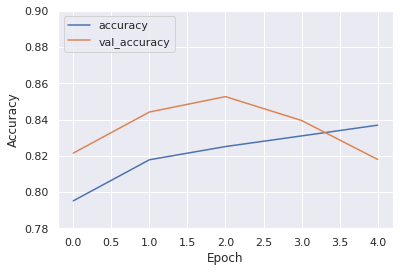

In [88]:
plt.plot(weighted_history.epoch, weighted_history.history['accuracy'], label='accuracy')
plt.plot(weighted_history.epoch, weighted_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.78, 0.9])
plt.legend(loc='upper left');

The model reaches an accuracy of about 82%.

In [0]:
weighted_predictions_prob = weighted_model.predict(X_test)
weighted_predictions = np.array([np.argmax(weighted_predictions_prob[i]) for i in range(len(weighted_predictions_prob))])

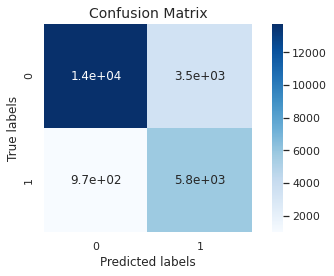

In [90]:
weighted_confusion = confusion_matrix(y_test, weighted_predictions, labels=[0,1])
plot_cm(weighted_confusion)

Here we see an improvement in the false negative, as they are reduce from 29% to 14%.

## Discussion

1. We trained a simple model, consisting of just one convolution layer and one hidden dense layer. We trained the model using just 25% of the total dataset, and it reached an accuracy of about 85%. However, the model has some pitfalls, one of which being the big number of false negatives it predicts. 
2. Then we trained a slightly more complex CNN model, consisting of 2 convolutional layers in the feature extraction part and 3 fully connected layers in the classifier part of the model. We obtained a slight improvement in the accuracy, as this model reaches 86%. However, we still have a big number of false negatives.
3. We started dealing with class imbalance by using the `class_weight` parameter in keras. This lead to a considerable reduction of the predicted false negatives, which dropped from 29% to 14%. 

The future improvements on which I would like to work on next are various, and include:
- using the **right metric** for optimization (recall, precision and f1_score are common metrics for imbalanced classification).

- **Tuning the hyperparameters** of the model (e.g., number of epochs, batch size, number of convolution layers, number of hidden layers, ...).

- Check for **overfitting** and add Dropout layers in between hidden layers to avoid it.


Finally, for the model to be a **relevant pre-processing step** in the automation of aggressiveness grading, it should keep track of the **x- and y-coordinate** of each sample. In this way the output would be readily usable by pathologist, who could then correctly localize and inspect the regions where IDC is present.